<a href="https://colab.research.google.com/github/newhouseb/handcrafted/blob/main/HandCrafted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install matplotlib tensorboard
import torch
import torch.nn.functional as F
import math
import torch.nn
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def plot_tensor(tensor):
    fig, ax = plt.subplots()
    im = ax.imshow(tensor, cmap='viridis') # You can use other colormaps like 'plasma', 'inferno', 'magma', etc.
    plt.show()

class Register(object):
    def __init__(self, name, size):
        self.name = name
        self.size = size
        self.offset = None

class Embedding(object):
    def __init__(self, tokens: list[str], registers: list[Register]):
        self.tokens = tokens
        self.token_map = { t: i for i,t in enumerate(tokens) }
        self.registers = registers
        self.register_map = {}
        self.register_size = 0
        
        if len(registers) == 0 or registers[0].name != 'pos':
            raise Exception("First register must be 'pos'") 
        
        offset = len(tokens)
        for reg in registers:
            reg.offset = offset
            offset += reg.size
            self.register_size += reg.size
            self.register_map[reg.name] = reg
            
        self.dim = len(tokens) + self.register_size

    def tokenize(self, string: str):
        return F.one_hot(torch.tensor([self.token_map[c] for c in string]), num_classes=len(self.tokens)).float()

    def embed(self, sequence):
        # We want to create additional space to store the registers
        extension_tensor = torch.zeros(*sequence.shape[:-1], self.register_size)

        # Encode position in the first extra embedding dimension
        for i in range(sequence.shape[0]):
            extension_tensor[i, 0] = math.sin(i*(2*math.pi)/100)
            extension_tensor[i, 1] = math.cos(i*(2*math.pi)/100)

        sequence = torch.cat((sequence, extension_tensor), dim=-1)

        return sequence
    
    def predict(self, sequence):
        return self.tokens[torch.argmax(sequence[-1,:len(self.tokens)])]

class AttentionLayer(torch.nn.Module):
    def __init__(self, instruction):
        super(AttentionLayer, self).__init__()
        
        self.key = torch.nn.Parameter(instruction.key)
        self.value = torch.nn.Parameter(instruction.value)
        self.query = torch.nn.Parameter(instruction.query)
        
        self.softmax = torch.nn.Softmax(2)
        
    def forward(self, seq):
        batch_size, seq_length, dim = seq.shape
        
        query = seq @ self.query
        key = seq @ self.key
        value = seq @ self.value

        causal_mask = (torch.triu(torch.ones(seq_length, seq_length), diagonal=1)*-1e10).to(seq.device)
        norm = np.sqrt(dim)
        
        kq = self.softmax(query @ key.transpose(-2, -1) / norm + causal_mask)
        
        s = kq @ value
        
        return (seq + s)
    
    def size(self):
        return torch.numel(self.instruction.query) + torch.numel(self.instruction.query) + torch.numel(self.instruction.query)
    
    def reset(self):
        torch.nn.init.xavier_uniform_(self.key)
        torch.nn.init.xavier_uniform_(self.query)
        torch.nn.init.xavier_uniform_(self.value)
    
class MLPLayer(torch.nn.Module):
    def __init__(self, instruction, debug=False):
        super(MLPLayer, self).__init__()
        self.debug = debug
        
        self.first_weights = torch.nn.Parameter(instruction.first_weights)
        self.first_bias = torch.nn.Parameter(instruction.first_bias)
        self.second_weights = torch.nn.Parameter(instruction.second_weights)
        self.second_bias = torch.nn.Parameter(instruction.second_bias)
        
        self.gelu = torch.nn.GELU()
        
    def forward(self, seq):
        a = self.gelu(seq @ self.first_weights + self.first_bias)
        if self.debug:
            plot_tensor(a)
        b = (a @ self.second_weights)
        if self.debug:
            plot_tensor(b)
        x = b + self.second_bias
        if self.debug:
            plot_tensor(x)
        return seq + x
    
    def size(self):
        return (torch.numel(self.instruction.first_weights) + torch.numel(self.instruction.first_bias) 
                + torch.numel(self.instruction.second_weights) + torch.numel(self.instruction.second_bias))
    
    def reset(self):
        torch.nn.init.xavier_uniform_(self.first_weights)
        torch.nn.init.zeros_(self.first_bias)
        torch.nn.init.xavier_uniform_(self.second_weights)
        torch.nn.init.zeros_(self.second_bias)
    
tokens = list('0123456789+= \n')
pos = Register('pos', 2)
left_pos = Register('left_pos', 2)
right_pos = Register('right_pos', 2)
out_pos = Register('out_pos', 2)
left_digit = Register('left', len(tokens))
right_digit = Register('right', len(tokens))
out_digit = Register('out', len(tokens))
final_digit = Register('final', len(tokens))
carry = Register('carry', 1)
distance = Register('distance', 1)

embedding = Embedding(tokens, [pos, left_pos, right_pos, out_pos, left_digit, right_digit, out_digit, carry, distance, final_digit])
        
class FindAndStore(AttentionLayer):
    def __init__(self, embedding: Embedding, token: str, register: Register):
        pos_reg = embedding.register_map['pos']
        
        # No matter the current token, we attend to if the attended token is the given token
        token_select = torch.zeros(embedding.dim, embedding.dim) - 1e10
        token_select[:, int(embedding.token_map[token])] = 1e10

        position_select = torch.zeros(embedding.dim, embedding.dim)
        position_select[pos_reg.offset, register.offset] = 1.0
        position_select[pos_reg.offset + 1, register.offset + 1] = 1.0
        
        self.key = torch.eye(embedding.dim)
        self.query = token_select
        self.value = position_select        
        
        super(FindAndStore, self).__init__(self)

ex = embedding.embed(embedding.tokenize('10+10=2111')) 
        
class GetRelativeToken(AttentionLayer):
    def __init__(self, embedding: Embedding, pos_reg: Register, steps: int, out: Register):
        tpos_reg = embedding.register_map['pos']
        
        position_select = torch.zeros(embedding.dim, embedding.dim)
        position_select[tpos_reg.offset, tpos_reg.offset] = 1e10
        position_select[tpos_reg.offset + 1, tpos_reg.offset + 1] = 1e10

        i = -steps
        sin = math.sin(i*(2*math.pi)/100)*1
        cos = math.cos(i*(2*math.pi)/100)*1

        rotation = torch.zeros(embedding.dim, embedding.dim)
        rotation[pos_reg.offset, tpos_reg.offset] = cos
        rotation[pos_reg.offset + 1, tpos_reg.offset] = -sin
        rotation[pos_reg.offset, tpos_reg.offset + 1] = sin
        rotation[pos_reg.offset + 1, tpos_reg.offset + 1] = cos
        #plot_tensor(rotation)
        
        token_copy = torch.zeros(embedding.dim, embedding.dim)
        for i in range(len(embedding.tokens)):
            token_copy[i, i + out.offset] = 1.0
            
        self.query = rotation
        self.key = position_select
        self.value = token_copy
        
        super(GetRelativeToken, self).__init__(self)
        
class Multiply(MLPLayer):
    def __init__(self, embedding: Embedding, left_token: Register, right_token: Register, carry: Register, out_token: Register):
        width = 10*10*2

        self.first_weights = torch.zeros(embedding.dim, width)
        self.first_bias = torch.zeros(width)
        
        self.second_weights = torch.zeros(width, embedding.dim)
        self.second_bias = torch.zeros(embedding.dim)

        idx = 0
        for i in range(0, 10):
            for j in range(0, 10):
                self.first_weights[left_token.offset + i, idx] = 500
                self.first_weights[right_token.offset + j, idx] = 500
                self.first_weights[carry.offset, idx] = -1000
                self.first_bias[idx] = -900
                self.second_weights[idx, out_token.offset + (i + j) % 10] = 0.01
                if (i + j) >= 10:
                    self.second_weights[idx, carry.offset] = 0.01
                idx += 1
                
                self.first_weights[left_token.offset + i, idx] = 333
                self.first_weights[right_token.offset + j, idx] = 333
                self.first_weights[carry.offset, idx] = 333
                self.first_bias[idx] = -900
                self.second_weights[idx, out_token.offset + (i + j + 1) % 10] = 0.01 * (1.0/0.99)
                # If we need to carry, there was already a carry so we change nothing 
                if (i + j + 1) >= 10:
                    self.second_weights[idx, carry.offset] = 0.0
                # If we don't need to carry, we need to clear the carry bit,
                else:
                    self.second_weights[idx, carry.offset] = -0.01 * (1.0/0.99)
                idx += 1
                
        super(Multiply, self).__init__(self)

class Clear(MLPLayer):
    def __init__(self, embedding: Embedding, registers: list[Register]):
        self.first_weights = torch.zeros(embedding.dim, embedding.dim)
        self.first_bias = torch.zeros(embedding.dim)
        
        for reg in registers:
            for i in range(reg.size):
                self.first_weights[reg.offset + i, reg.offset + i] = 100.0
        
        self.second_weights = torch.zeros(embedding.dim, embedding.dim)
        self.second_bias = torch.zeros(embedding.dim)
        for reg in registers:
            for i in range(reg.size):
                self.second_weights[reg.offset + i, reg.offset + i] = -0.01
                
        super(Clear, self).__init__(self)
                
class DiffPos(MLPLayer):
    def __init__(self, embedding: Embedding, left_pos: Register, right_pos: Register, distance: Register):
        self.first_weights = torch.zeros(embedding.dim, 2)
        self.first_bias = torch.zeros(2)
        
        # Note: it's important that the x and y are multiplied by different numbers,
        # otherwise 1, 2 computes to be the same as 2, 1
        
        self.first_weights[left_pos.offset, 0] = 1e2
        self.first_weights[left_pos.offset + 1, 0] = 1e3
        self.first_weights[right_pos.offset, 0] = -1e2
        self.first_weights[right_pos.offset + 1, 0] = -1e3
        
        self.first_weights[left_pos.offset, 1] = -1e2
        self.first_weights[left_pos.offset + 1, 1] = -1e3
        self.first_weights[right_pos.offset, 1] = 1e2
        self.first_weights[right_pos.offset + 1, 1] = 1e3
        
        self.second_weights = torch.zeros(2, embedding.dim)
        self.second_bias = torch.zeros(embedding.dim)
        
        self.second_weights[0, distance.offset] = 1.0
        self.second_weights[1, distance.offset] = 1.0
        
        super(DiffPos, self).__init__(self)
        
class IsZero(MLPLayer):
    def __init__(self, embedding: Embedding, zero: Register):
        self.first_weights = torch.zeros(embedding.dim, 2)
        self.first_bias = torch.zeros(1)
        
        self.first_weights[zero.offset, 0] = -100.0
        self.first_weights[zero.offset, 1] = 1.0
        self.first_bias[0] = 10.0
        
        self.second_weights = torch.zeros(2, embedding.dim)
        self.second_bias = torch.zeros(embedding.dim)
        
        self.second_weights[0, zero.offset] = 0.1
        self.second_weights[1, zero.offset] = -1.0
        self.second_bias[zero.offset] = 10.0
        
        super(IsZero, self).__init__(self)

class CopyOnMatch(MLPLayer):
    def __init__(self, embedding: Embedding, match: Register, src: Register, dst: Register):
        self.first_weights = torch.zeros(embedding.dim, src.size)
        self.first_bias = torch.ones(src.size)
        
        for i in range(src.size):
            self.first_weights[match.offset, i] = 100
            self.first_weights[src.offset + i, i] = 100
            self.first_bias[i] = -190
        
        self.second_weights = torch.zeros(src.size, embedding.dim)
        self.second_bias = torch.zeros(embedding.dim)
        
        for i in range(src.size):
            self.second_weights[i, dst.offset + i] = 0.1
            
        super(CopyOnMatch, self).__init__(self)

class StepPosition(MLPLayer):
    def __init__(self, embedding: Embedding, positions: list[Register], offsets: list[Register]):

        rotation = torch.zeros(embedding.dim, embedding.dim)
        
        n = 0
        for reg in positions:
            i = offsets[n]
            sin = math.sin(-i*(2*math.pi)/100)*1
            cos = math.cos(-i*(2*math.pi)/100)*1
        
            rotation[reg.offset, reg.offset] = cos - 1
            rotation[reg.offset + 1, reg.offset] = -sin
            rotation[reg.offset, reg.offset + 1] = sin
            rotation[reg.offset + 1, reg.offset + 1] = cos - 1
            
            n += 1

        self.first_weights = rotation
        self.first_bias = torch.ones(embedding.dim)*1000
        
        self.second_weights = torch.eye(embedding.dim, embedding.dim)
        self.second_bias = torch.ones(embedding.dim)*-1000
        
        super(StepPosition, self).__init__(self)

In [4]:
import tqdm

class PaddedAddition(torch.nn.Module):
    def __init__(self):
        super(PaddedAddition, self).__init__()
        self.debug = False

        # Attention layer to search for the location of various tokens
        self.find_plus = FindAndStore(embedding, '+', left_pos)
        self.find_equal = FindAndStore(embedding, '=', right_pos)
        self.find_out = FindAndStore(embedding, '=', out_pos)

        # Fully connected layers to adjust positions by fixed amounts
        self.step_out = StepPosition(embedding, [out_pos], [-1])
        
        # Note: I've unrolled this because I was concerned the reuse of weights would do weird things with
        # backprop
        self.clear_lro_1 = Clear(embedding, [left_digit, right_digit, out_digit])
        self.step_pos_1 = StepPosition(embedding, [left_pos, right_pos, out_pos], [-1, -1, 1])
        self.read_left_1 = GetRelativeToken(embedding, left_pos, 0, left_digit)
        self.read_right_1 = GetRelativeToken(embedding, right_pos, 0, right_digit)
        self.multiply_1 = Multiply(embedding, left_digit, right_digit, carry, out_digit)
        self.diff_pos_1 = DiffPos(embedding, pos, out_pos, distance)
        self.is_zero_1 = IsZero(embedding, distance)
        self.copy_out_1 = CopyOnMatch(embedding, distance, out_digit, final_digit)

        # Linear layer to move the final digit to the out digit
        self.final_projection = torch.zeros(embedding.dim, final_digit.size)
        for i in range(final_digit.size):
            self.final_projection[final_digit.offset + i, i] = 1.0e6
        self.final_projection = torch.nn.Parameter(self.final_projection)
        
        self.softmax = torch.nn.Softmax(1)

    def generate(self, input_string):
        # First we embed the original string
        x = embedding.embed(embedding.tokenize(input_string))
        x = self(torch.unsqueeze(x, 0).to(self.final_projection.device))
        plot_tensor(x.detach().squeeze(0))
        return input_string + embedding.predict(x[0].detach())

    def forward(self, x):
        # Then we look for the various symbols that direct us to
        x = self.find_plus.forward(x)
        x = self.find_equal.forward(x)
        x = self.find_out.forward(x)
        x = self.step_out.forward(x)

        for _ in range(4):
          x = self.clear_lro_1.forward(x)
          x = self.step_pos_1.forward(x)
          x = self.read_left_1.forward(x)
          x = self.read_right_1.forward(x)
          x = self.multiply_1.forward(x)
          x = self.diff_pos_1.forward(x)
          x = self.is_zero_1.forward(x)
          x = self.copy_out_1.forward(x)

        if self.debug:
            plot_tensor(x.detach().squeeze(0))
            
        x = x @ self.final_projection
        return x
    
    def reset(self):
        torch.nn.init.xavier_uniform_(self.final_projection)
        for child in self.children():
            if hasattr(child, 'reset'):
                child.reset()

def read_out(x):
    print('Out:', torch.argmax(x[-1,out_digit.offset:out_digit.offset + out_digit.size]))
    


In [5]:
def random_addition():
    left = int(np.random.rand()*999)
    right = int(np.random.rand()*999)

    out = str(left + right).zfill(4)[::-1]
    left = str(left).zfill(4)
    right = str(right).zfill(4)
    
    # Note: I've made the strings of constant length to make batch SGD easier
    leftpadding = np.random.randint(0, 5)*' '
    rightpadding = (5 - len(leftpadding))*' ' # np.random.randint(0, 5)*' '
    return leftpadding + left + '+' + rightpadding + right + '=' + out
    
random_addition()

'   0294+  0626=0290'

In [6]:
from torch.utils.tensorboard import SummaryWriter

model = PaddedAddition()
model.reset()

writer = SummaryWriter()
step = 0

In [11]:
from torch.utils.data import TensorDataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batched_inputs = []
batched_outputs = []

seen = {}
duplicates = 0

i = 0
while i < 100000:
    # Generate a random addition
    input_string = random_addition()
    if input_string in seen:
        duplicates += 1
        continue
    seen[input_string] = True
    i += 1
    
    inputs = embedding.embed(embedding.tokenize(input_string))
    
    # The output is the last character with the position masked out
    outputs = inputs[-4:,:len(embedding.tokens)]
    outputs = outputs*1e6
    batched_outputs.append(outputs)
    
    # The input is the sequence with the last bit removed
    inputs = inputs[:-1,:]   
    batched_inputs.append(inputs)
    
dataset = TensorDataset(torch.stack(batched_inputs).to(device), torch.stack(batched_outputs).to(device))
train_set, val_set = torch.utils.data.random_split(dataset, [90000, 10000])
dataloader = DataLoader(train_set, batch_size=8192, shuffle=True)
validation_loader = DataLoader(val_set, batch_size=8192, shuffle=False)
print("Duplicates", duplicates)

cuda
Duplicates 1048


In [12]:
import torch.optim as optim

model.to(device)
model.debug = False

loss_fn = torch.nn.CrossEntropyLoss()
loss_fn.train()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)

def check_pred(expected, predicted):
    expected_indices = torch.argmax(expected, dim=2)
    predicted_indices = torch.argmax(predicted, dim=2)
    correct = torch.sum(expected_indices == predicted_indices)
    return [correct.item(), expected.shape[0]*4] # 4 characters per prediction

for epoch in range(10000):
    train_loss = 0
    train_correct = 0
    train_total = 0
    for batch_inputs, batch_outputs in dataloader:
        output = model(batch_inputs)
        pred_output = output[:, -4:,:]        
        loss = loss_fn(pred_output.transpose(1, 2), batch_outputs.transpose(1, 2))
        
        acc = check_pred(pred_output, batch_outputs)
        train_correct += acc[0]
        train_total += acc[1]
        
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        train_loss += loss
        
    val_loss = 0
    val_correct = 0
    val_total = 0
    for batch_inputs, batch_outputs in validation_loader:
        output = model(batch_inputs)
        pred_output = output[:, -4:,:]        
        loss = loss_fn(pred_output.transpose(1, 2), batch_outputs.transpose(1, 2))
        
        acc = check_pred(pred_output, batch_outputs)
        val_correct += acc[0]
        val_total += acc[1]
        
        val_loss += loss
        
    step += 1
    writer.add_scalars('Loss', {
        'train': train_loss / train_total,
        'validation': val_loss / val_total
    }, step)
    writer.add_scalars('Accuracy', {
        'train': train_correct / train_total,
        'validation': val_correct / val_total
    }, step)

    scheduler.step()
    
    if epoch % 100 == 0:
        print('Epoch {} loss: {}'.format(epoch, loss.item()))

Epoch 0 loss: 50792248.0
Epoch 100 loss: 559948.9375
Epoch 200 loss: 42849.1640625
Epoch 300 loss: 394.06982421875
Epoch 400 loss: 0.04262639582157135


KeyboardInterrupt: 

In [15]:
torch.save(model.state_dict(), 'state_dict_learned.pt')
torch.save(optimizer.state_dict(), 'optimizer_dict_learned.pt')

 0906+    0338=4421


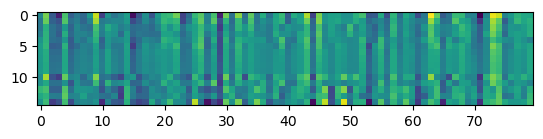

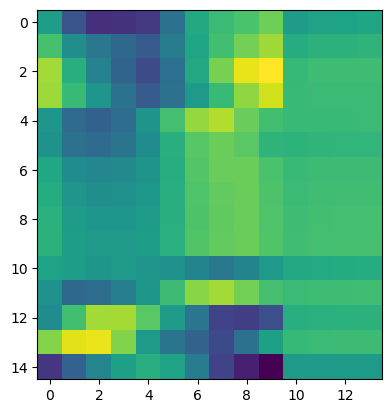

 0906+    0338=4


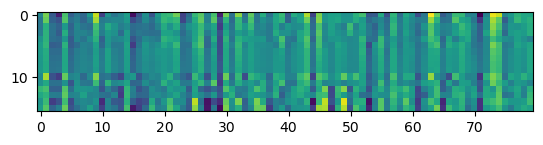

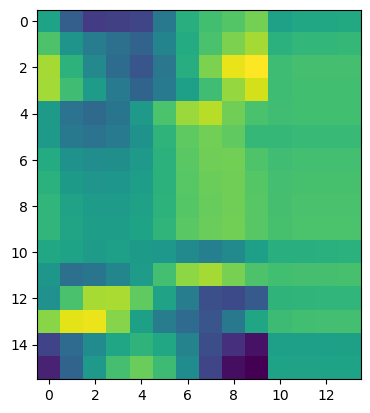

 0906+    0338=44


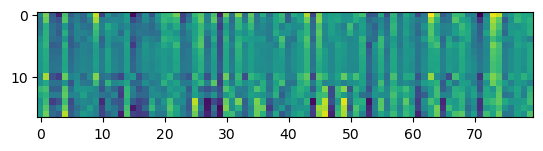

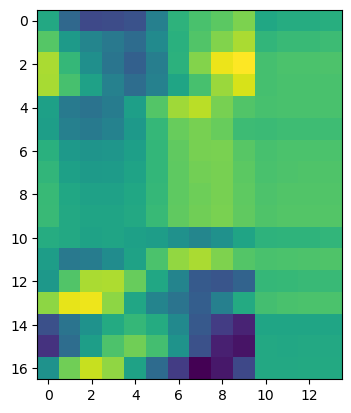

 0906+    0338=442


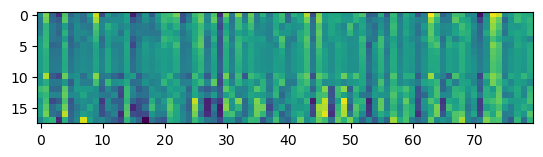

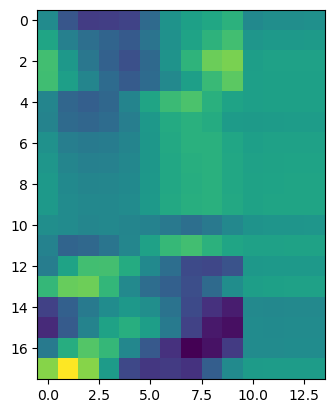

 0906+    0338=4421


In [13]:
m = model
test = random_addition()
print(test)
test = test.split('=')[0] + '='
m.eval()
m.cpu()
m.debug = True
for i in range(4):
    test = m.generate(test)
    print(test)

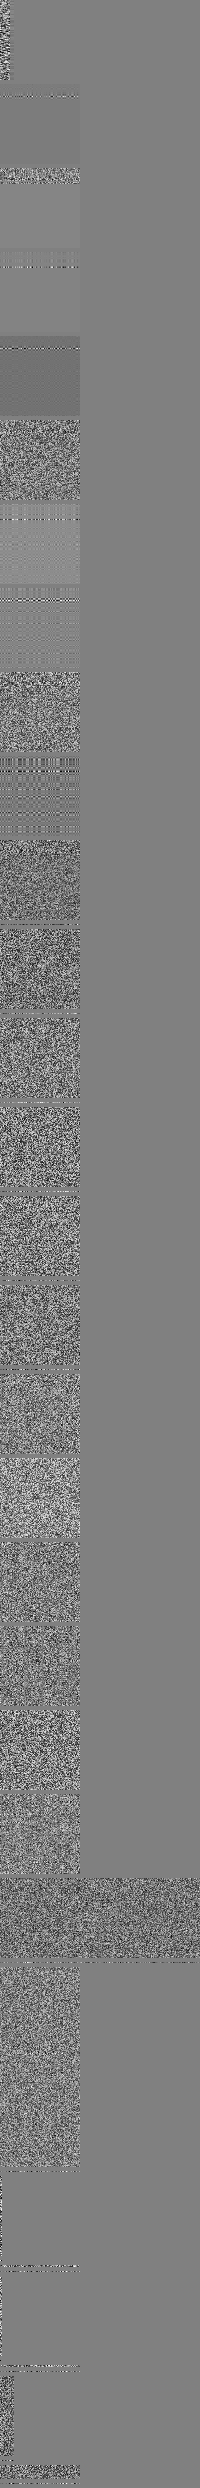

In [14]:
from PIL import Image

height = 0
width = 0
for param in model.parameters():

    width = max(width, param.shape[0])
    if len(param.shape) == 1:
        height += 1 + 4
    else:
        height += param.shape[0] + 4

bigimg = Image.new('L', (width, height), (128))

offset = 0
for tensor in model.parameters():
    if len(tensor.shape) == 1:
        tensor = tensor.unsqueeze(0)
    
    tensor = ((tensor - tensor.min()) * (255 / (tensor.max() - tensor.min()))).type(torch.uint8)
    
    img = Image.fromarray(tensor.detach().cpu().numpy())
    bigimg.paste(img, (0,offset))
    
    offset += tensor.shape[0] + 4

bigimg

In [582]:
out = model.final_projection.detach().cpu()

for reg in embedding.registers:
    print(reg.name)
    print(out[reg.offset:reg.offset + reg.size, :])

torch.set_printoptions(profile="full")

pos
tensor([[ 0.3124,  0.3011, -0.0086,  0.2367, -0.1226, -0.3739, -0.4570, -0.2650,
         -0.3226, -0.1408, -0.3409, -0.2077, -0.0979, -0.2772],
        [ 0.0259,  0.0737,  0.1287, -0.0710, -0.0608, -0.0091,  0.1733,  0.0893,
          0.0207, -0.0683, -0.1859,  0.0177, -0.1752, -0.1745]])
left_pos
tensor([[ 0.0640,  0.1090,  0.0469,  0.0734,  0.2607, -0.0196,  0.1205,  0.1068,
         -0.0250,  0.0543, -0.3994, -0.4839, -0.0013, -0.3120],
        [ 0.0705, -0.0570, -0.0873,  0.1094,  0.1083,  0.0838, -0.0609, -0.0540,
         -0.3363, -0.1628, -0.1756, -0.2228,  0.1011, -0.1742]])
right_pos
tensor([[ 0.1758,  0.0760,  0.2257, -0.1593, -0.0248, -0.0369, -0.2197, -0.1258,
         -0.1955, -0.1271, -0.3490, -0.0257, -0.2241, -0.3001],
        [ 0.1711,  0.0599, -0.2461, -0.1435, -0.0819,  0.0837,  0.0836,  0.1541,
          0.2341,  0.2982, -0.4000, -0.3016, -0.0097, -0.1869]])
out_pos
tensor([[ 0.1570,  0.1196,  0.2042, -0.0973,  0.0371, -0.0554, -0.2600, -0.3206,
         -0.068